# Pumped-Storage Optimisation with Genetic Algorithm and MILP

In [2]:
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.graph_objs as go
import plotly.express as px
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import os
from itertools import product

# Import own implementations
from milp import MILP
import genetic
from genetic import GA_Actions_Elite

# Importing tuning libraries
import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

%load_ext blackcellmagic

## Reading the Price data

In [2]:
df = pd.read_csv("../01 - Data/example_week.csv")
df.head(2)

,spot,utc_time
0,101.54,2022-01-01 00:00:00+00:00
1,52.13,2022-01-01 01:00:00+00:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   spot      168 non-null    float64
 1   utc_time  168 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


## The Power Plant

In [4]:
plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = (
    plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
)
plant_params["PUMP_RATE_M3H"] = (
    plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
)
plant_params["MAX_STORAGE_MWH"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * plant_params["TURBINE_POWER_MW"]

## MILP

In [5]:
milp_solver = MILP(plant_params=plant_params, spot=df["spot"], utc_time=df["utc_time"])

In [6]:
milp_model, milp_status, milp_profile = milp_solver.solve()

In [7]:
milp_status

'Optimal'

In [8]:
milp_profile.head()

,water_level,action,colour_id,utc_time,spot
0,0.0,0,nothing,2022-01-01 00:00:00+00:00,101.54
1,375.0,-1,pump,2022-01-01 01:00:00+00:00,52.13
2,750.0,-1,pump,2022-01-01 02:00:00+00:00,20.78
3,1125.0,-1,pump,2022-01-01 03:00:00+00:00,15.66
4,1500.0,-1,pump,2022-01-01 04:00:00+00:00,21.47


In [9]:
global_optimum = milp_model.objective.value()
global_optimum

350291.0

## GA Actions

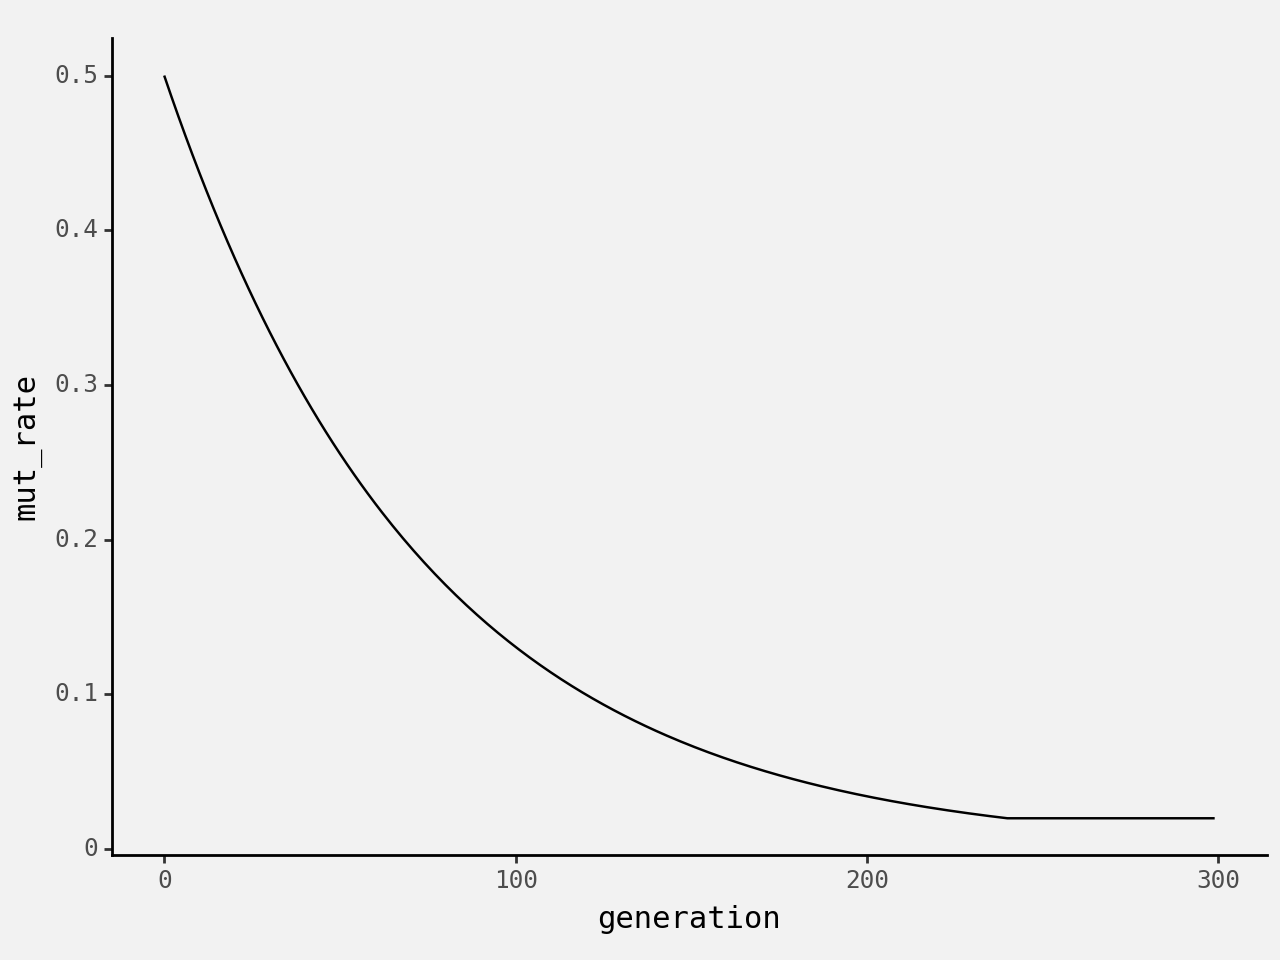

<Figure Size: (640 x 480)>

In [5]:
initial_mutation_rate = 0.5
final_mutation_rate = 0.02
total_generations = 300
intersection_point = 0.8

decay = (
    pd.DataFrame({"generation": np.arange(0, 300)}).assign(
        mut_rate=lambda x: np.where(
            x["generation"] <= int(intersection_point * total_generations),
            initial_mutation_rate
            * np.exp(
                (np.log(final_mutation_rate) - np.log(initial_mutation_rate))
                / (intersection_point * total_generations)
            )**x["generation"],
            0.02,
        )
    )
)

(
    pn.ggplot(
        data=decay,
        mapping=pn.aes(x="generation", y="mut_rate"),
    )
    + pn.geom_line()
)

In [21]:
np.full_like([1,2,3], 1/len([1,2,3]), dtype=float)

array([0.33333333, 0.33333333, 0.33333333])

In [17]:
np.full_like(, 0.5)

array([0, 0, 0])

### Training

The best config during tuning was:

```
{'CXPB': 0.5529678171381575,
 'MUTPB': 0.05004027982289111,
 'MUT_IND_PB': 0.6603704827300051,
 'TOURNAMENT_SIZE': 8.0,
 'POP_SIZE': 5000.0}
```

Let's use this to train the genetic algorithm.

In [10]:
best_config = {
    "MUTPB": 1,
    "POP_SIZE": 5000,
    "MUT_IND_PB": 0.05,
    "ELITISM": 0.1,
}

In [11]:
ga_solver = GA_Actions_Elite(
    plant_params=plant_params, spot=df["spot"], utc_time=df["utc_time"]
)

population, fitnesses, best_ind, history = ga_solver.train(
    config=best_config, total_generations=300, tune_mode=False
)

  0%|          | 0/300 [00:00<?, ?it/s]

Selected: 500
Std dev weighting: 0.0014576900175156042
Weighting: 500
Selected: 500
Std dev weighting: 0.010088568708893868
Weighting: 500
Selected: 500
Std dev weighting: 0.002545017915221768
Weighting: 500
Selected: 500
Std dev weighting: 0.0012007022306257272
Weighting: 500
Selected: 500
Std dev weighting: 0.0018088634991950043
Weighting: 500
Selected: 500
Std dev weighting: 0.00192989384807464
Weighting: 500
Selected: 500
Std dev weighting: 0.001666126073012885
Weighting: 500
Selected: 500
Std dev weighting: 0.0016556367633133171
Weighting: 500
Selected: 500
Std dev weighting: 0.0015728734892214036
Weighting: 500
Selected: 500
Std dev weighting: 0.0016014609675594265
Weighting: 500
Selected: 500
Std dev weighting: 0.0015560522161406252
Weighting: 500
Selected: 500
Std dev weighting: 0.0015170747924793731
Weighting: 500
Selected: 500
Std dev weighting: 0.0015124311941767806
Weighting: 500
Selected: 500
Std dev weighting: 0.0016287079859687438
Weighting: 500
Selected: 500
Std dev wei

ValueError: 'p' must be 1-dimensional

In [ ]:
history

,generation,best,average,worst
0,0,-293032.0,-9980398.028,-10460514.0
1,1,-297433.0,-9738494.206,-10389603.0
2,2,-243306.0,-9532594.974,-10409811.0
3,3,-161953.0,-9400322.812,-10345659.0
4,4,-153819.0,-9079379.224,-10440012.0
...,...,...,...,...
295,295,298162.0,-442471.250,-9750296.0
296,296,298162.0,-142067.478,-9744398.0
297,297,298162.0,-202000.952,-9749372.0
298,298,298162.0,-82016.506,-9722400.0


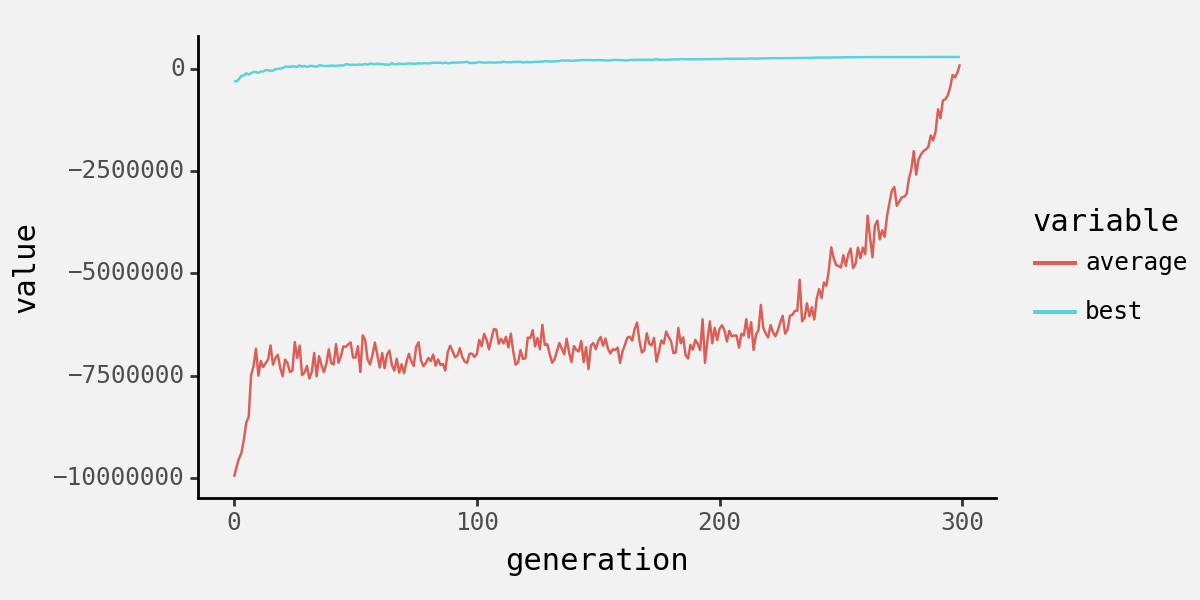

<Figure Size: (600 x 300)>

In [ ]:
(
    pn.ggplot(
        data=(
            history.drop("worst", axis=1)
            .melt(id_vars="generation")
        ),
        mapping=pn.aes(x="generation", y="value", colour="variable"),
    )
    + pn.geom_line()
    + pn.theme(figure_size=[6, 3])
    # + pn.scale_y_log10()
)